In [1]:
# Imports for data manipulation
import pandas as pd
import numpy as np
import pickle

In [2]:
# Importa for data visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [32]:
# Load the CSV file into a DataFrame
crime_data = pd.read_csv('../data/crime-data_crime-data_crimestat.csv')

C:\Users\aarav\AppData\Local\Temp\ipykernel_13872\3131610019.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data = pd.read_csv('../data/crime-data_crime-data_crimestat.csv')


In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def aggregate_crimes_by_zip(crime_data):
    """
    This function aggregates crimes by ZIP code for Phoenix area ZIPs (85001 - 85100).
    """
    # Phoenix + Tempe ZIP code range
    zip_codes = list(range(85001, 85099)) + list(range(85280, 85289))
    
    # Filter for Phoenix ZIP codes
    filtered_crime_data = crime_data[crime_data['ZIP'].isin(zip_codes)]
    
    # Group by ZIP and count crimes
    crime_count_by_zip = filtered_crime_data['ZIP'].value_counts().reset_index()
    crime_count_by_zip.columns = ['ZIP', 'Crime Count']
    
    return crime_count_by_zip

crime_count_by_zip = aggregate_crimes_by_zip(crime_data)
crime_count_by_zip


        ZIP  Crime Count
0   85015.0        28032
1   85008.0        26679
2   85051.0        25213
3   85009.0        24759
4   85041.0        23580
5   85017.0        22253
6   85035.0        21305
7   85043.0        20384
8   85021.0        19345
9   85029.0        17704
10  85033.0        17127
11  85016.0        16471
12  85023.0        16331
13  85040.0        16330
14  85032.0        15745
15  85042.0        15046
16  85022.0        14941
17  85034.0        13087
18  85019.0        12940
19  85037.0        12553
20  85031.0        12244
21  85020.0        11484
22  85013.0        11417
23  85006.0        11231
24  85027.0        10930
25  85007.0        10332
26  85018.0         9660
27  85014.0         9521
28  85053.0         8584
29  85004.0         8267
30  85044.0         7904
31  85003.0         7714
32  85085.0         4833
33  85012.0         3819
34  85050.0         3593
35  85048.0         3349
36  85024.0         3288
37  85054.0         3079
38  85028.0         2814


In [131]:
print(crime_count_by_zip)


        ZIP  Crime Count
0   85015.0        28032
1   85008.0        26679
2   85051.0        25213
3   85009.0        24759
4   85041.0        23580
5   85017.0        22253
6   85035.0        21305
7   85043.0        20384
8   85021.0        19345
9   85029.0        17704
10  85033.0        17127
11  85016.0        16471
12  85023.0        16331
13  85040.0        16330
14  85032.0        15745
15  85042.0        15046
16  85022.0        14941
17  85034.0        13087
18  85019.0        12940
19  85037.0        12553
20  85031.0        12244
21  85020.0        11484
22  85013.0        11417
23  85006.0        11231
24  85027.0        10930
25  85007.0        10332
26  85018.0         9660
27  85014.0         9521
28  85053.0         8584
29  85004.0         8267
30  85044.0         7904
31  85003.0         7714
32  85085.0         4833
33  85012.0         3819
34  85050.0         3593
35  85048.0         3349
36  85024.0         3288
37  85054.0         3079
38  85028.0         2814


In [81]:
# #create a function that will look at 'UCR_CRIME_CATEGORY' and give a classfication of crimes based on text entries with "ASSUALT", "THEFT" and "OTHER"
# def classify_crime(crime_data):
#     """
#     This function classifies crimes into categories (ASSAULT, THEFT, OTHER) and returns counts.
#     """
#     if 'UCR CRIME CATEGORY' not in crime_data.columns:
#         raise ValueError("The DataFrame must contain a 'UCR CRIME CATEGORY' column.")
    
#     # Create a column for crime classification
#     crime_data['Crime Classification'] = 'OTHER'
    
#     # Classify crimes
#     assault_indices = crime_data[crime_data['UCR CRIME CATEGORY'].str.contains('AGGRAVATED ASSAULT|RAPE|MURDER', case=False)].index
#     theft_indices = crime_data[crime_data['UCR CRIME CATEGORY'].str.contains('BURGLARY|LARCENY|MOTOR VEHICLE|ROBBERY', case=False)].index
#     other_indices = crime_data[~crime_data.index.isin(assault_indices) & ~crime_data.index.isin(theft_indices)].index
    
#     # Assign classifications
#     crime_data.loc[assault_indices, 'Crime Classification'] = 'ASSAULT'
#     crime_data.loc[theft_indices, 'Crime Classification'] = 'THEFT'
#     crime_data.loc[other_indices, 'Crime Classification'] = 'OTHER'
    
#     # Return the counts
#     return len(assault_indices), len(theft_indices), len(other_indices)

# assault_count, theft_count, other_count = classify_crime(crime_data)
# print(f"Assault count: {assault_count}", f"Theft count: {theft_count}", f"Other count: {other_count}")

Assault count: 62180 Theft count: 440758 Other count: 56679


In [127]:
# print(type(classify_crime(crime_data)))

<class 'tuple'>


In [123]:
# def train_crime_classifier(crime_data):
#     # Prepare features and target
#     features = create_features(crime_data)

#     # Debug: Check the structure of `features`
#     print(features.head())  # Check first few rows
#     print(features.columns)  # Check the column names to make sure it's a DataFrame

#     # Define the target variable based on 'Crime Count' levels
#     bins = [0, 10, 50, 100, float('inf')]
#     labels = ['LOW', 'MEDIUM', 'HIGH', 'VERY HIGH']
#     features['Crime Level'] = pd.cut(features['Crime Count'], bins=bins, labels=labels)

#     # Features for the model (excluding 'ZIP' and target)
#     X = features.drop(['ZIP', 'Crime Count', 'Crime Level'], axis=1)
#     y = features['Crime Level']

#     # Debug: Ensure that X and y are properly formed
#     print(X.head())
#     print(y.head())

#     # Split data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train the Random Forest classifier
#     model = RandomForestClassifier(n_estimators=100, random_state=42)
#     model.fit(X_train, y_train)

#     return model


In [124]:
# def predict_crime_levels(crime_data, model):
#     """
#     This function predicts crime levels for each ZIP code using the trained model.
#     """
#     # Create features from crime data
#     features = create_features(crime_data)
    
#     # Prepare features for prediction (excluding 'ZIP' and target)
#     X = features.drop(['ZIP', 'Crime Count', 'Crime Level'], axis=1)

#     # Predict crime levels
#     features['Predicted Crime Level'] = model.predict(X)

#     return features[['ZIP', 'Predicted Crime Level']]


In [158]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def aggregate_crimes_by_zip(crime_data):
    """
    This function aggregates crimes by ZIP code for Phoenix and Tempe area ZIPs (85001 - 85099, 85280 - 85289).
    """
    # Phoenix + Tempe ZIP code range
    zip_codes = list(range(85001, 85099)) + list(range(85280, 85289))
    
    # Filter for Phoenix ZIP codes
    filtered_crime_data = crime_data[crime_data['ZIP'].isin(zip_codes)]
    
    # Group by ZIP and count crimes
    crime_count_by_zip = filtered_crime_data['ZIP'].value_counts().reset_index()
    crime_count_by_zip.columns = ['ZIP', 'Crime Count']
    
    return crime_count_by_zip

def classify_crime(crime_data):
    """
    This function classifies crimes into categories (ASSAULT, THEFT, OTHER) and adds the classifications as a new column in the DataFrame.
    """
    if 'UCR CRIME CATEGORY' not in crime_data.columns:
        raise ValueError("The DataFrame must contain a 'UCR CRIME CATEGORY' column.")
    
    # Create a column for crime classification
    crime_data['Crime Classification'] = 'OTHER'
    
    # Classify crimes
    assault_indices = crime_data[crime_data['UCR CRIME CATEGORY'].str.contains('AGGRAVATED ASSAULT|RAPE|MURDER', case=False)].index
    theft_indices = crime_data[crime_data['UCR CRIME CATEGORY'].str.contains('BURGLARY|LARCENY|MOTOR VEHICLE|ROBBERY', case=False)].index
    other_indices = crime_data[~crime_data.index.isin(assault_indices) & ~crime_data.index.isin(theft_indices)].index
    
    # Assign classifications
    crime_data.loc[assault_indices, 'Crime Classification'] = 'ASSAULT'
    crime_data.loc[theft_indices, 'Crime Classification'] = 'THEFT'
    crime_data.loc[other_indices, 'Crime Classification'] = 'OTHER'
    
    return crime_data  # Return the updated DataFrame


def create_features(crime_data):
    """
    This function creates features for the Random Forest model based on the crime data.
    """
    # Classify crimes and update crime_data
    crime_data = classify_crime(crime_data)
    
    # Aggregate crimes by ZIP code
    crime_by_zip = aggregate_crimes_by_zip(crime_data)
    
    # Create feature DataFrame based on aggregated crime counts by ZIP
    features = crime_by_zip.copy()
    
    # Create additional features (e.g., proportion of different crime classifications)
    classification_counts = crime_data.groupby('ZIP')['Crime Classification'].value_counts().unstack(fill_value=0)
    
    # Ensure proper column names
    classification_counts.columns = ['ASSAULT', 'THEFT', 'OTHER']
    
    # Merge aggregated crime counts with classification counts
    features = features.merge(classification_counts, on='ZIP', how='left').fillna(0)
    
    return features  # Return the features DataFrame


def train_crime_classifier(crime_data):
    """
    This function trains a Random Forest classifier on the crime data.
    """
    # Prepare features and target
    features = create_features(crime_data)

    # Debug: Check the structure of features DataFrame
    print("Features DataFrame before processing:")
    print(features.head())
    print(features.columns)  # Show all column names

    # Check if 'Crime Count' exists in the DataFrame
    if 'Crime Count' not in features.columns:
        raise KeyError("'Crime Count' column not found in features.")

    # Convert 'Crime Count' to numeric
    features['Crime Count'] = pd.to_numeric(features['Crime Count'], errors='coerce').fillna(0)

    # Define the target variable based on 'Crime Count' levels
    bins = [0, 10, 50, 100, float('inf')]
    labels = ['LOW', 'MEDIUM', 'HIGH', 'VERY HIGH']

    # Create the 'Crime Level' column
    features['Crime Level'] = pd.cut(features['Crime Count'], bins=bins, labels=labels, include_lowest=True)
    
    # Debug: Check if 'Crime Level' was created successfully
    print("Crime Level created successfully:", 'Crime Level' in features.columns)

    # Debug: Inspect the features DataFrame after creating Crime Level
    print(features.head())  # Inspect the first few rows of features

    # Features for the model (excluding 'ZIP' and target)
    X = features.drop(['ZIP', 'Crime Count', 'Crime Level'], axis=1)
    y = features['Crime Level']

    # Debug: Check X and y
    print("X (features):\n", X.head())
    print("y (target):\n", y.head())

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model



def predict_crime_levels(crime_data, model):
    """
    This function predicts crime levels for each ZIP code using the trained model.
    """
    # Create features from crime data
    features = create_features(crime_data)
    
    # Prepare features for prediction (excluding 'ZIP' and target)
    X = features.drop(['ZIP', 'Crime Count'], axis=1)

    # Predict crime levels
    features['Predicted Crime Level'] = model.predict(X)

    return features[['ZIP', 'Predicted Crime Level']]  # Return ZIP and predicted crime levels



In [160]:
model = train_crime_classifier(crime_data)
predicted_crime_levels = predict_crime_levels(crime_data, model)
predicted_crime_levels.to_csv('predicted_crime_levels_output.csv', index=False)


Features DataFrame before processing:
       ZIP  Crime Count  ASSAULT  THEFT  OTHER
0  85015.0        28032     3110   3320  21602
1  85008.0        26679     3252   3235  20192
2  85051.0        25213     2774   3259  19180
3  85009.0        24759     3049   3461  18249
4  85041.0        23580     2635   1815  19130
Index(['ZIP', 'Crime Count', 'ASSAULT', 'THEFT', 'OTHER'], dtype='object')
Crime Level created successfully: True
       ZIP  Crime Count  ASSAULT  THEFT  OTHER Crime Level
0  85015.0        28032     3110   3320  21602   VERY HIGH
1  85008.0        26679     3252   3235  20192   VERY HIGH
2  85051.0        25213     2774   3259  19180   VERY HIGH
3  85009.0        24759     3049   3461  18249   VERY HIGH
4  85041.0        23580     2635   1815  19130   VERY HIGH
X (features):
    ASSAULT  THEFT  OTHER
0     3110   3320  21602
1     3252   3235  20192
2     2774   3259  19180
3     3049   3461  18249
4     2635   1815  19130
y (target):
 0    VERY HIGH
1    VERY HIGH
2   

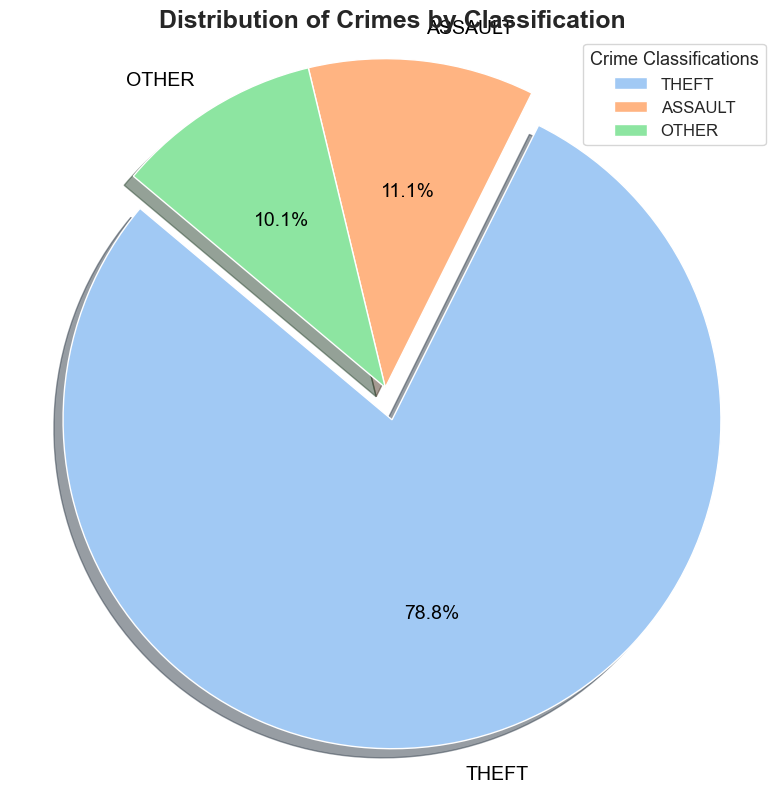

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style using Seaborn
sns.set(style='whitegrid')

def plot_crime_distribution(crime_data):
    """
    This function creates a stylized pie chart showing the distribution of crime classifications.
    """
    # Classify crimes to get the 'Crime Classification' column
    crime_data = classify_crime(crime_data)
    
    # Count the occurrences of each classification
    classification_counts = crime_data['Crime Classification'].value_counts()

    # Define the data for the pie chart
    labels = classification_counts.index.tolist()
    sizes = classification_counts.values.tolist()  # Count of each classification
    colors = sns.color_palette("pastel", n_colors=len(sizes))  # Use Seaborn pastel color palette
    explode = [0.1] + [0] * (len(sizes) - 1)  # Explode the first slice

    # Create the pie chart
    plt.figure(figsize=(8, 8))  # Set the figure size
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140,
            textprops={'fontsize': 14, 'color': 'black'})  # Custom text properties

    # Equal aspect ratio ensures that pie chart is drawn as a circle
    plt.axis('equal')

    # Add a title with a larger font size and a different font family
    plt.title('Distribution of Crimes by Classification', fontsize=18, fontweight='bold', fontfamily='sans-serif')

    # Create a custom legend
    plt.legend(labels, title="Crime Classifications", title_fontsize='13', loc="upper right", fontsize='12')

    # Show the plot
    plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
    plt.show()

# Assuming crime_data is your DataFrame
plot_crime_distribution(crime_data)


In [101]:
def classify_level_from_counts(crime_counts):
    """
    This function classifies the crime level based on the aggregated crime counts.
    """
    def classify_level(count):
        if count > 150:
            return 'Very High'
        elif 100 < count <= 150:
            return 'High'
        elif 50 <= count <= 100:
            return 'Moderate'
        elif 10 <= count < 50:
            return 'Low'
        else:
            return 'Very Low'
    
    crime_counts['Level'] = crime_counts['Crime Count'].apply(classify_level)
    return crime_counts

# Example Usage
# Assuming crime_data is your initial DataFrame
# 1. Classify crimes
assault_count, theft_count, other_count = classify_crime(crime_data)

# 2. Aggregate crimes by ZIP code
aggregated_crimes = aggregate_crimes_by_zip(crime_data)

# 3. Classify levels based on aggregated crime counts
final_crime_levels = classify_level_from_counts(aggregated_crimes)

# Display the result
final_crime_levels.to_csv('classified_data.csv', index=False)
print("Classified crime data has been saved to classified_data.csv")



Classified crime data has been saved to classified_data.csv


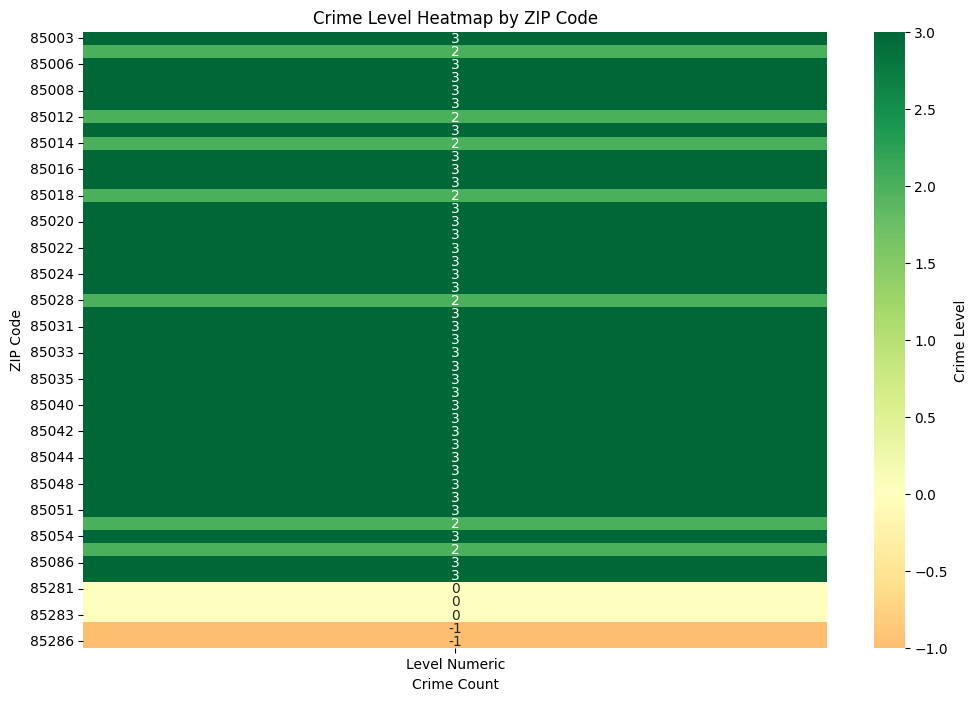

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the data from the CSV file
file_path = 'classified_data.csv'  # Update with the path to your CSV file
df = pd.read_csv(file_path)

df['ZIP'] = df['ZIP'].astype(int)


# Step 2: Convert the crime levels to numerical values for heatmap representation
level_mapping = {
    'Very High': 3,
    'High': 2,
    'Medium': 1,
    'Low': 0,
    'Very Low': -1
}

df['Level Numeric'] = df['Level'].map(level_mapping)

# Step 3: Create a heatmap using pivot_table to handle duplicates
plt.figure(figsize=(12, 8))
heatmap_data = df.pivot_table(index='ZIP', values='Level Numeric', aggfunc='mean')

# Use a diverging palette to distinguish levels
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn', center=0, cbar_kws={'label': 'Crime Level'})

plt.title('Crime Level Heatmap by ZIP Code')
plt.xlabel('Crime Count')  # You can change this label based on the structure you want
plt.ylabel('ZIP Code')
plt.show()


In [111]:
# import pandas as pd
# from geopy.geocoders import Nominatim
# import time
# from geopy.exc import GeocoderTimedOut

# # Create a geolocator object with a user agent
# geolocator = Nominatim(user_agent="Geopy_Library")

# def geocode_with_retry(address, attempts=3, timeout=10):
#     """
#     This function tries to geocode the address multiple times in case of a timeout.
#     """
#     for i in range(attempts):
#         try:
#             location = geolocator.geocode(address, timeout=timeout)
#             if location:
#                 return location.latitude, location.longitude
#             else:
#                 return None, None
#         except GeocoderTimedOut:
#             print(f"Timeout error on attempt {i+1} for address: {address}. Retrying...")
#             time.sleep(2)  # Wait 2 seconds before retrying
#     return None, None  # Return None after exceeding the number of attempts

# def geocode_address(row):
#     """
#     This function takes a row of data and returns latitude and longitude 
#     by geocoding the address using the Nominatim geocoder.
#     """
#     address = row['100 BLOCK ADDR'].replace("XX", "00")  # Replace XX with 00
#     zip_code = row['ZIP']
#     full_address = f"{address}, Phoenix, AZ {zip_code}, USA"
    
#     # Call the retry-enabled geocoding function
#     return pd.Series(geocode_with_retry(full_address))

# # Load the data from the CSV file
# crime_data = pd.read_csv('../data/crime-data_crime-data_crimestat.csv')

# # Apply the geocoding function with retries to the DataFrame
# crime_data[['Latitude', 'Longitude']] = crime_data.apply(geocode_address, axis=1)

# # Display the result
# print(crime_data)

# # Save the updated DataFrame to a new CSV file
# crime_data.to_csv('crime_data_with_coordinates.csv', index=False)


C:\Users\aarav\AppData\Local\Temp\ipykernel_13872\315955869.py:38: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data = pd.read_csv('../data/crime-data_crime-data_crimestat.csv')


KeyboardInterrupt: 

In [64]:
import openai

# Function to call Gemini API with a population prompt
def get_population_data(zip_code, api_key):
    # Set up your API key (You can set it from an environment variable for security)
    openai.api_key = api_key

    # The prompt you want to send to the API
    prompt = f"""
    You are a data retrieval assistant. I need the total population for a given U.S. zip code from 2015 to 2023.
    For the zip code {zip_code}, retrieve the population values for each year (2015-2023), and provide both individual year populations and the total sum.

    Please return the information in the following format:

    Input zip code: {zip_code}

    Yearly populations:
    2015: [population]
    2016: [population]
    2017: [population]
    ...
    2023: [population]

    Total population (2015-2023): [total]

    Use the most reliable datasets available (e.g., U.S. Census, government resources).
    """

    # Send the prompt to Gemini
    response = openai.Completion.create(
        model="gemini-1.5-flash-002",  # Or whichever Gemini model you are using
        prompt=prompt,
        max_tokens=300,  # Adjust the length as needed
        n=1,
        stop=None,
        temperature=0.5
    )

    # Get the response from Gemini
    output = response['choices'][0]['text']
    return output

# Input the zip code and API key
zip_code = "85281"  # Change this to your zip code
  # Replace with your Gemini API key

APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


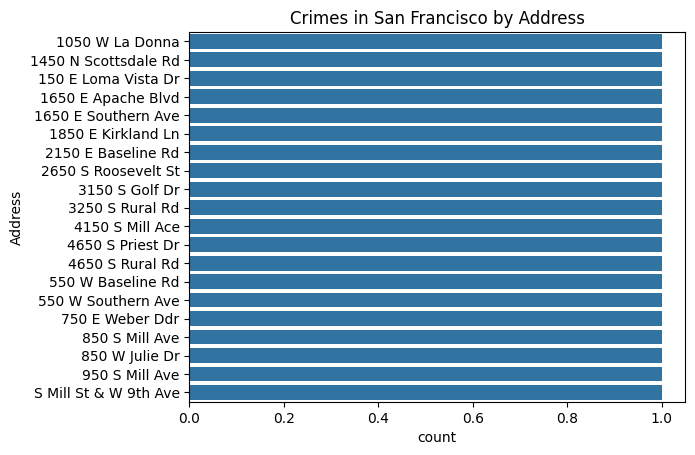

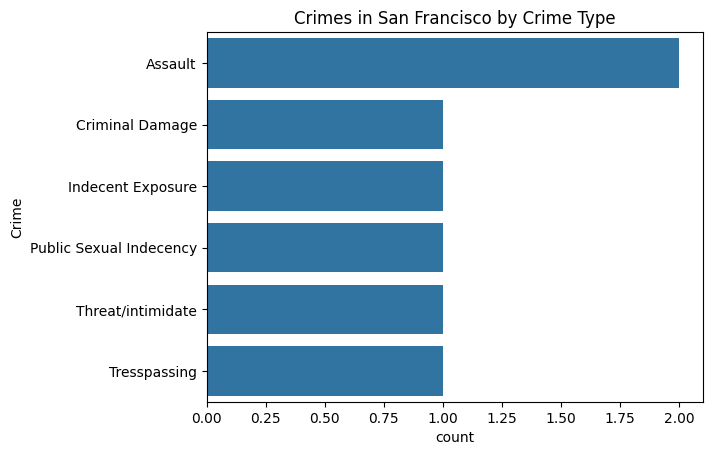

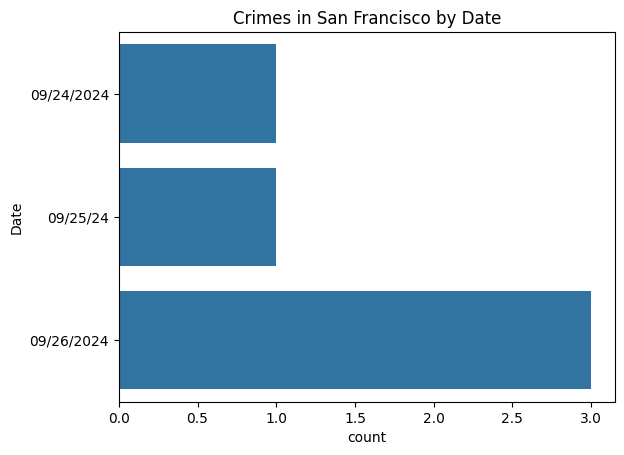

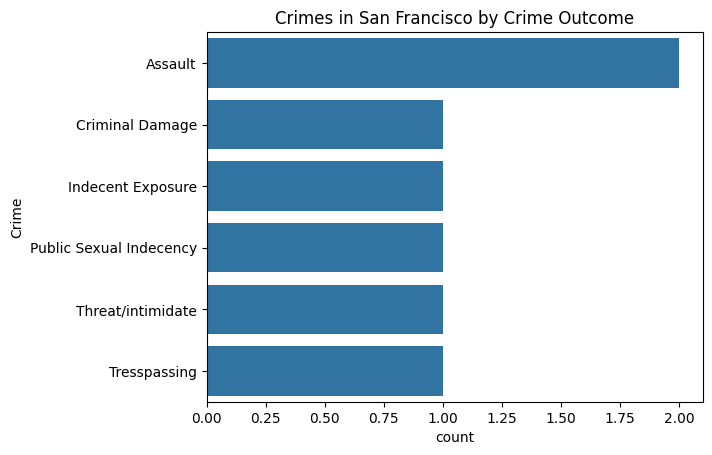

In [31]:
plotCrimeCounts(sfdata, columnsToPlotSF, 'San Francisco')

In [30]:
# # Read bosdata
# import re
# import warnings

# bos_file = '../data/crime.csv'
# target_type = str  # The desired output type

# with warnings.catch_warnings(record=True) as ws:
#     warnings.simplefilter("always")

#     bosData = pd.read_csv(bos_file, sep=",", header=0, encoding='ISO-8859-1')
#     print("Warnings raised:", ws)
#     # We have an error on specific columns, try and load them as string
#     for w in ws:
#         s = str(w.message)
#         print("Warning message:", s)
#         match = re.search(r"Columns \(([0-9,]+)\) have mixed types\.", s)
#         if match:
#             columns = match.group(1).split(',') # Get columns as a list
#             columns = [int(c) for c in columns]
#             print("Applying %s dtype to columns:" % target_type, columns)
#             bosData.iloc[:,columns] = bosData.iloc[:,columns].astype(target_type)

Warnings raised: []


In [33]:
# # Create histograms on some important metrics for Boston
# columnsToPlotBos = { 'Reporting District' : 'DISTRICT', 
#                      'Offense Type' : 'OFFENSE_CODE_GROUP',
#                      'Year' : 'YEAR', 
#                      'Month' : 'MONTH',
#                      'Day of the Week' : 'DAY_OF_WEEK'}